<a href="https://colab.research.google.com/github/Thaukor/t4ia/blob/main/Copy_of_2023_2_UOH_COM4402_Tarea_4_DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 4: Aprendizaje Profundo Avanzado**

### **DeepDream**

### Estudiante: Claudio Cárcamo

DeepDream es un experimento que visualiza los patrones aprendidos por una red neuronal. De forma similar a cuando un niño observa las nubes e intenta interpretar formas aleatorias, DeepDream sobreinterpreta y mejora los patrones que ve en una imagen.

Para ello, envía una imagen a través de la red y, a continuación, calcula el gradiente de la imagen con respecto a las activaciones de una capa determinada. A continuación, la imagen se modifica para aumentar estas activaciones, mejorando los patrones vistos por la red y dando como resultado una imagen onírica. Este proceso se denominó "Inceptionismo" (en referencia a [InceptionNet](https://arxiv.org/pdf/1409.4842.pdf), y a la [película](https://en.wikipedia.org/wiki/Inception) Inception).

Vamos a demostrar cómo se puede hacer que una red neuronal "sueñe" y realce los patrones surrealistas que ve en una imagen.

![Dogception](https://www.tensorflow.org/tutorials/generative/images/dogception.png)

In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

## Elija una imagen para analizar

Para este código, vamos a utilizar una imagen de un [labrador](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg).

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

83281/83281 [==============================] - 0s 0us/step


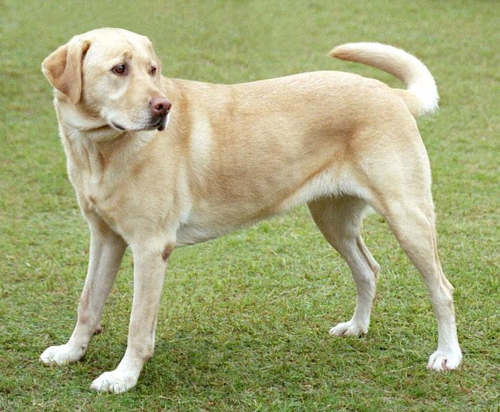

In [ ]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

## Preparar el modelo de extracción de características

Descargue y prepare un modelo de clasificación de imágenes preentrenado. Utilizarás [InceptionV3](https://keras.io/api/applications/inceptionv3/) que es similar al modelo utilizado originalmente en DeepDream. Tenga en cuenta que cualquier [modelo pre-entrenado](https://keras.io/api/applications/#available-models) funcionará, aunque tendrá que ajustar los nombres de las capas a continuación si cambia esto.

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87910968/87910968 [==============================] - 1s 0us/step


La idea en DeepDream es elegir una capa (o capas) y maximizar la "pérdida" de forma que la imagen "excite" cada vez más las capas. La complejidad de las características incorporadas depende de las capas elegidas por usted, es decir, las capas inferiores producen trazos o patrones simples, mientras que las capas más profundas dan características sofisticadas en las imágenes, o incluso objetos enteros.

La arquitectura de InceptionV3 es bastante grande (para un gráfico de la arquitectura del modelo, véase [research repo](https://github.com/tensorflow/models/tree/master/research/slim) de TensorFlow). Para DeepDream, las capas de interés son aquellas en las que se concatenan las convoluciones. Hay 11 de estas capas en InceptionV3, llamado 'mixed0' a 'mixed10'. El uso de diferentes capas dará como resultado diferentes imágenes oníricas. Las capas más profundas responden a características de nivel superior (como ojos y caras), mientras que las capas más tempranas responden a características más simples (como bordes, formas y texturas). Siéntase libre de experimentar con las capas seleccionadas a continuación, pero tenga en cuenta que las capas más profundas (las que tienen un índice más alto) tardarán más en entrenarse, ya que el cálculo del gradiente es más profundo.

In [ ]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

## Calcular la pérdida

La pérdida es la suma de las activaciones en las capas elegidas. La pérdida se normaliza en cada capa para que la contribución de las capas más grandes no supere la de las capas más pequeñas. Normalmente, la pérdida es una cantidad que se desea minimizar mediante el descenso gradiente. En DeepDream, maximizará esta pérdida mediante el ascenso por gradiente.

In [ ]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

## Gradiente ascendente

Una vez calculadas las pérdidas de las capas elegidas, sólo queda calcular los gradientes respecto a la imagen y añadirlos a la imagen original.

Añadir los gradientes a la imagen realza los patrones vistos por la red. En cada paso, habrá creado una imagen que excita cada vez más las activaciones de determinadas capas de la red.

El método que hace esto, a continuación, se envuelve en un `tf.function` para el rendimiento. Utiliza un `input_signature` para asegurar que la función no se repite para diferentes tamaños de imagen o valores de `steps`/`step_size`. Consulte la [Guía de funciones concretas](../../guide/function.ipynb) para más detalles.

In [ ]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [ ]:
deepdream = DeepDream(dream_model)

## Loop principal

In [ ]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

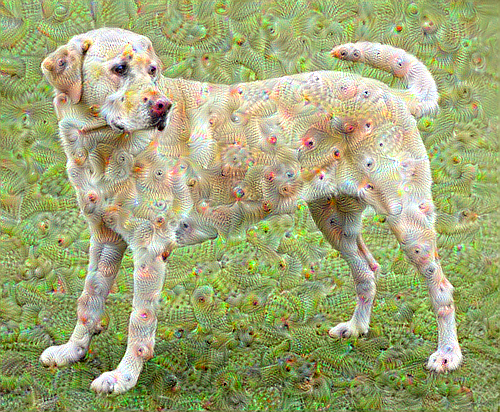

In [ ]:
dream_img = run_deep_dream_simple(img=original_img,
                                  steps=100, step_size=0.01)

## Subiendo una octava

Bastante bien, pero hay algunos problemas con este primer intento:

  1. La salida es ruidosa (esto podría abordarse con una pérdida `tf.image.total_variation`).
  1. La imagen es de baja resolución.
  1. 2. Los patrones parecen producirse todos con la misma granularidad.
  
Un enfoque que aborda todos estos problemas es aplicar el ascenso de gradiente a diferentes escalas. Esto permitirá que los patrones generados a escalas más pequeñas se incorporen a patrones a escalas más altas y se rellenen con detalles adicionales.

Para ello, puede aplicar el método anterior de ascenso por gradiente, aumentar el tamaño de la imagen (lo que se denomina una octava) y repetir el proceso en varias octavas.

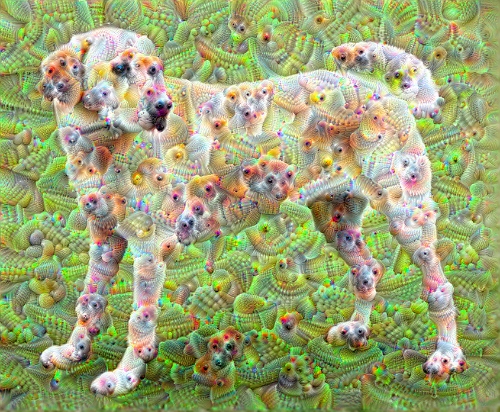

13.417875528335571

In [ ]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

## Opcional: Escalado con tiles

Una cosa a tener en cuenta es que a medida que la imagen aumenta de tamaño, también lo hará el tiempo y la memoria necesarios para realizar el cálculo del gradiente. La implementación de octava anterior no funcionará en imágenes muy grandes, o de muchas octavas.

Para evitar este problema, puede dividir la imagen en mosaicos y calcular el gradiente para cada mosaico.

La aplicación de desplazamientos aleatorios a la imagen antes de cada cálculo en mosaico evita que aparezcan costuras en los mosaicos.

Empiece por aplicar el desplazamiento aleatorio:

In [ ]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

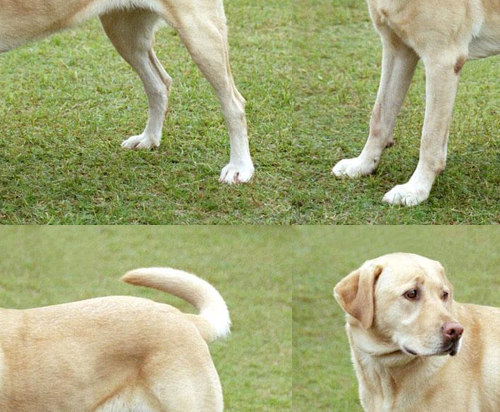

In [ ]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

He aquí un equivalente en mosaico de la función `deepdream` definida anteriormente:

In [ ]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8

    return gradients

In [ ]:
get_tiled_gradients = TiledGradients(dream_model)

La combinación de todos estos elementos da lugar a una aplicación de deepdream escalable y sensible a la octava:

In [ ]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01,
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))

  result = deprocess(img)
  return result

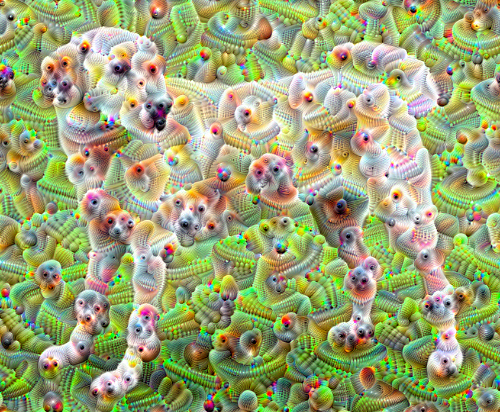

In [ ]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)